# Imports

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'  # Need to fix my PyTorch installation

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from copy import deepcopy
from ReTorch.models import LSTM, NN
from ReTorch.losses import MSE, gaussian_loss
from ReTorch.optim import AdamHD, Adam
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)
np.random.seed(0)

# Data pre-processing functions

In [4]:
def convert_timestamp(timestamps):
    return [datetime.datetime.strptime(timestamp,'%Y-%m-%d') for timestamp in timestamps.values]

def normalise(data, return_stats=False):
    mean, std = np.mean(data), np.std(data)
    if not return_stats:
        return (data-mean)/std
    return (data-mean)/std, mean, std

# Importing and sorting avocado dataset

In [5]:
avocado_data = pd.read_csv("data/avocado.csv", index_col=0)
avocado_data = avocado_data[avocado_data["region"] != "TotalUS"]  # Remove whole of US entry
avocado_data["Date"] = convert_timestamp(avocado_data["Date"])
avocado_data = avocado_data.sort_values("Date")
avocado_data

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,0.97,153506.84,105203.79,19147.78,468.70,28686.57,13653.15,15033.42,0.00,conventional,2015,Jacksonville
51,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.00,conventional,2015,BaltimoreWashington
51,2015-01-04,1.83,7301.30,6.81,630.24,0.00,6664.25,6664.25,0.00,0.00,organic,2015,NorthernNewEngland
51,2015-01-04,0.97,540234.22,398670.03,54844.33,39.07,86680.79,38505.18,48175.61,0.00,conventional,2015,MiamiFtLauderdale
51,2015-01-04,1.35,9895.96,4634.70,1647.92,0.00,3613.34,3613.34,0.00,0.00,organic,2015,DallasFtWorth
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2018-03-25,1.43,20507.49,687.46,2729.79,0.00,16887.00,13920.18,2966.82,0.00,organic,2018,Detroit
0,2018-03-25,1.70,190257.38,29644.09,70982.10,0.00,89631.19,89424.11,207.08,0.00,organic,2018,California
0,2018-03-25,1.47,207028.28,2946.60,85213.80,63349.05,55518.83,29054.93,7662.55,18801.35,conventional,2018,GrandRapids
0,2018-03-25,1.60,24825.50,6516.40,685.92,44.09,17579.09,16514.58,1064.51,0.00,organic,2018,Denver


Identifying unique regions from time series, splitting into training and test sequences.

In [51]:
unique_regions = avocado_data["region"].unique()
train_regions = unique_regions[:36]
test_regions = unique_regions[36:]
print(train_regions, test_regions)

['Jacksonville' 'BaltimoreWashington' 'NorthernNewEngland'
 'MiamiFtLauderdale' 'DallasFtWorth' 'Orlando' 'Midsouth' 'Philadelphia'
 'Syracuse' 'PhoenixTucson' 'Columbus' 'Nashville' 'Northeast'
 'Pittsburgh' 'NewOrleansMobile' 'Plains' 'Spokane' 'Portland' 'NewYork'
 'RaleighGreensboro' 'Houston' 'RichmondNorfolk' 'CincinnatiDayton'
 'Tampa' 'Roanoke' 'Denver' 'HarrisburgScranton' 'GreatLakes'
 'Indianapolis' 'HartfordSpringfield' 'StLouis' 'LasVegas' 'GrandRapids'
 'LosAngeles' 'Louisville' 'Detroit'] ['Atlanta' 'Boise' 'Chicago' 'Charlotte' 'Southeast' 'California' 'West'
 'BuffaloRochester' 'SouthCentral' 'SouthCarolina' 'Albany' 'Seattle'
 'Boston' 'Sacramento' 'SanFrancisco' 'SanDiego' 'WestTexNewMexico']


# Data pre-processing

Here we are making the assumption that the mean and standard deviation of the test data outputs is known.
These could be calculated using earlier time series or possibly learnt with another simple model.

In [8]:
region_stats = dict()

def create_dataset(regions):
    x_out = None
    y_out = None

    for region in regions:
        d1 = avocado_data.loc[(avocado_data["region"] == region) & (avocado_data["type"]=="conventional")]
        time_stamps, avg_price, volume = d1["Date"], d1["AveragePrice"].values, d1["Total Volume"].values
        price, mean_price, std_price = normalise(avg_price, True)
        volume,  mean_vol, std_vol = normalise(volume, True)
        price = torch.tensor(price, dtype=torch.float32).view(-1, 1)
        volume = torch.tensor(volume, dtype=torch.float32).view(-1, 1)
        region_stats[region] = {"mean_price": mean_price, "mean_vol": mean_vol, 
                                "std_price": std_price, "std_vol": std_vol}
        if x_out is None:
            x_out = volume
            y_out = price
        else:
            x_out = torch.cat((x_out, volume), dim=1)
            y_out = torch.cat((y_out, price), dim=1)

    return x_out.unsqueeze(-1), y_out.unsqueeze(-1)

x_train, y_train = create_dataset(train_regions)
x_test, y_test = create_dataset(test_regions)

# Plotting sample time series

Can see there is a roughly inverse relationship between volume and price - were are making the assumption that the mean and standard deviation are known priori, these could be estiated from earlier time series.

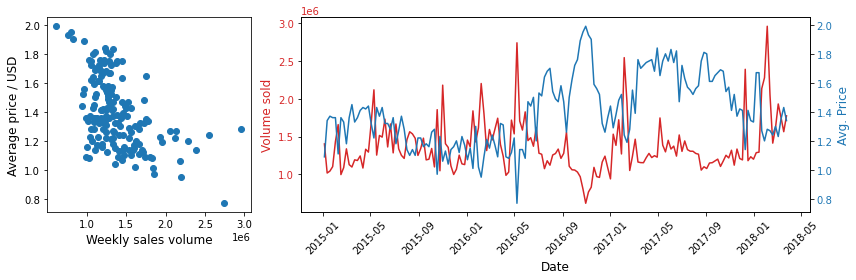

In [9]:
region = "NewYork"

d1 = avocado_data.loc[(avocado_data["region"] == region) & (avocado_data["type"]=="conventional")]
time_stamps, avg_price, volume = d1["Date"], d1["AveragePrice"], d1["Total Volume"]


fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 2.5]})

ax_s, ax1 = ax
ax_s.scatter(volume, avg_price)
ax_s.set_ylabel("Average price / USD", size=12)
ax_s.set_xlabel("Weekly sales volume", size=12)
    
color = 'tab:red'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Volume sold', color=color, fontsize=12)
ax1.plot(time_stamps, volume, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Avg. Price', color=color, fontsize=12)
ax2.plot(time_stamps, avg_price, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.title(f"Avocado sales and avg. price in {region}", fontsize=12)
plt.savefig("NewYork")
plt.show()

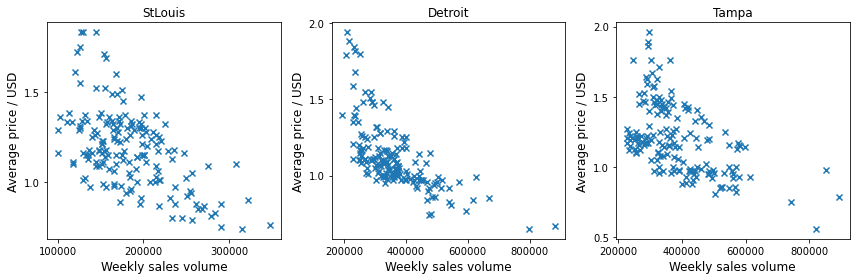

In [10]:
regions = ["StLouis", "Detroit", "Tampa"]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, region in enumerate(regions):
    d1 = avocado_data.loc[(avocado_data["region"] == region) & (avocado_data["type"]=="conventional")]
    time_stamps, avg_price, volume = d1["Date"], d1["AveragePrice"], d1["Total Volume"]

    ax[i].scatter(volume, avg_price, marker="x")
    ax[i].set_ylabel("Average price / USD", size=12)
    ax[i].set_xlabel("Weekly sales volume", size=12)
    ax[i].set_title(f"{region}")
    ax[i].locator_params(nbins=4)
    #ax[i].set_xlim(0.5e6, 3e6)
fig.tight_layout()
plt.savefig("correlation")
plt.show();

# Training LSTM

LSTM model trained to predict sequence of normalised average costs 

In [11]:
def lstm_prediction(lstm_model, x, gaussian=False):
    y_dim = 1
    sequence_length, batch_dim, x_dim = x.size()
    h = torch.zeros((batch_dim, hidden_dim))
    c = torch.zeros((batch_dim, hidden_dim))
    y_preds = torch.zeros((sequence_length, batch_dim, y_dim))

    if gaussian:
        y_log_vars = torch.zeros((sequence_length, batch_dim, y_dim))

    for i, x_t in enumerate(x):
        h, c, y = lstm_model(x_t, h, c)
        if gaussian:
            y_preds[i] = y[:, :y_dim]
            y_log_vars[i] = y[:, y_dim:]
        else:
            y_preds[i] = y

    if gaussian:
        return y_preds, y_log_vars
    return y_preds


def train_lstm(lstm_model, optimiser, gaussian):
    training_losses = []
    test_losses = []
    best_epoch, min_test_loss = 0, 1e10
    early_stopping_time = 1000 # No. epochs to continue if test loss not decreasing
    
    def train_step(epoch, gaussian):
        if gaussian:
            y_preds, y_log_vars = lstm_prediction(lstm_model, x_train, gaussian)
            loss = gaussian_loss(y_preds, y_log_vars, y_train)
        else:
            y_preds = lstm_prediction(lstm_model, x_train)
            loss = MSE(y_preds, y_train)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        return loss

    def test_step(epoch, gaussian):
        with torch.no_grad():
            if gaussian:
                y_preds, y_log_vars = lstm_prediction(lstm_model, x_test, gaussian)
                test_loss = gaussian_loss(y_preds, y_log_vars, y_test)
            else:
                y_preds = lstm_prediction(lstm_model, x_test)
                test_loss = MSE(y_test, y_preds)
        return test_loss

    for epoch in range(epochs):
        train_loss = train_step(epoch, gaussian)
        test_loss = test_step(epoch, gaussian)
        training_losses.append(train_loss)
        test_losses.append(test_loss)
        if not epoch % (epochs//10):
            print(f"Epoch {epoch} | Train loss : {train_loss} | Test loss : {test_loss}")
        if test_loss < min_test_loss:
            best_epoch = deepcopy(epoch)
            min_test_loss = test_loss
            best_params = deepcopy(lstm_model.parameters())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        if epochs_without_improvement == early_stopping_time:
            print(f"Stopping early at epoch {epoch}")
            print(f"Epoch {epoch} | Train loss : {train_loss} | Test loss : {test_loss}")
            break
        
    print(f"Using best params from epoch {best_epoch} | Test loss : {min_test_loss}")
    return training_losses, test_losses, best_params

# Training with regular Adam

In [12]:
hidden_dim = 100
gaussian = True
output_dim = y_train.size(-1)
output_dim = (1+gaussian)*output_dim  # Double output dimension if Gaussian (mean, variance)
sequence_length, batch_dim, x_dim = x_train.size()
lstm1 = LSTM(x_dim, hidden_dim, output_dim, y_layer1=100)
adam = Adam(lstm1.parameters())
epochs = 500

training_losses1, test_losses1, best_params = train_lstm(lstm1, adam, gaussian)

Epoch 0 | Train loss : 0.7045584321022034 | Test loss : 0.5564166903495789
Epoch 50 | Train loss : 0.30477625131607056 | Test loss : 0.33506301045417786
Epoch 100 | Train loss : 0.00974324345588684 | Test loss : 0.028698474168777466
Epoch 150 | Train loss : -0.12902748584747314 | Test loss : -0.08711028099060059
Epoch 200 | Train loss : -0.14995497465133667 | Test loss : -0.11346009373664856
Epoch 250 | Train loss : -0.2593837380409241 | Test loss : -0.1651495099067688
Epoch 300 | Train loss : -0.28517699241638184 | Test loss : -0.19773459434509277
Epoch 350 | Train loss : -0.36509668827056885 | Test loss : -0.28645503520965576
Epoch 400 | Train loss : -0.27095457911491394 | Test loss : -0.15994054079055786
Epoch 450 | Train loss : -0.4006471037864685 | Test loss : -0.28845226764678955
Using best params from epoch 498 | Test loss : -0.31081074476242065


# Training with hypergradient Adam

In [13]:
hidden_dim = 100
gaussian = True
output_dim = y_train.size(-1)
output_dim = (1+gaussian)*output_dim  # Double output dimension if Gaussian (mean, variance)
sequence_length, batch_dim, x_dim = x_train.size()
lstm_final = LSTM(x_dim, hidden_dim, output_dim, y_layer1=100)
adamhd = AdamHD(lstm_final.parameters(), alpha_lr=5e-9)
epochs = 500
training_losses2, test_losses2, best_params2 = train_lstm(lstm_final, adamhd, gaussian)

Epoch 0 | Train loss : 1.232075810432434 | Test loss : 1.1019163131713867
Epoch 50 | Train loss : 0.021957993507385254 | Test loss : 0.20656412839889526
Epoch 100 | Train loss : -0.024473369121551514 | Test loss : 0.05691215395927429
Epoch 150 | Train loss : 0.07075145840644836 | Test loss : 0.07085499167442322
Epoch 200 | Train loss : -0.2957761585712433 | Test loss : -0.22622668743133545
Epoch 250 | Train loss : -0.22720849514007568 | Test loss : -0.19791579246520996
Epoch 300 | Train loss : -0.46729105710983276 | Test loss : -0.24249392747879028
Epoch 350 | Train loss : -0.39523324370384216 | Test loss : -0.15425312519073486
Epoch 400 | Train loss : -0.5799112915992737 | Test loss : -0.2790483236312866
Epoch 450 | Train loss : -0.7306355834007263 | Test loss : -0.17045438289642334
Using best params from epoch 404 | Test loss : -0.32207828760147095


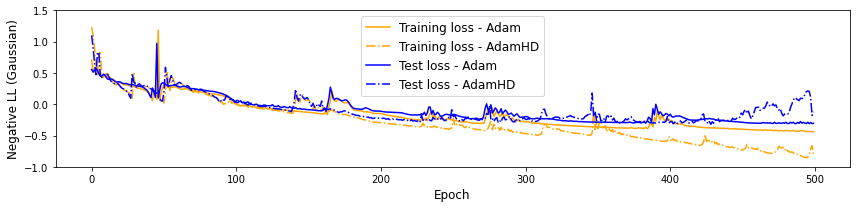

In [14]:
fig, ax = plt.subplots( figsize=(12,3))
ax.plot(list(range(len(training_losses1))), training_losses1, color="orange", label="Training loss - Adam")
ax.plot(list(range(len(training_losses1))), training_losses2, ls="-.", color="orange", label="Training loss - AdamHD")
ax.plot(list(range(len(test_losses1))), test_losses1, color="blue", label="Test loss - Adam")
ax.plot(list(range(len(test_losses1))), test_losses2, ls="-.", color="blue", label="Test loss - AdamHD")
#plt.xlabel("Epochs")

for i in range(1):
    ax.set_ylim(-1, 1.5)
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Negative LL (Gaussian)", fontsize=12)
    ax.legend(fontsize=12)
fig.tight_layout()
plt.savefig("convergence")
plt.show()

# Plotting sample predictions

Given the time series of avocado volumes sold, the LSTM predicts the average price over the time series.

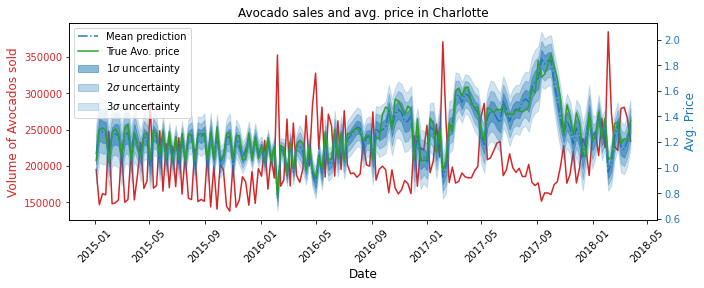

In [65]:
train =  False  # Set True to plot training data predictions

if train:
    x = x_test
    y = y_test
else:
    x = x_train
    y = y_train
    
with torch.no_grad():
    if gaussian:
        y_preds, y_log_vars = lstm_prediction(lstm_final, x, gaussian)
        y_stds = (0.5*y_log_vars).exp()
    else:
        y_preds = lstm_prediction(lstm_final, x, gaussian)
        
i = np.random.randint(0,17)  # Taking random region from test/train dataset
region_index = i + 36*(1-train)
region = unique_regions[region_index]
region_dict = region_stats[region]
c_mean, c_std = region_dict["mean_price"], region_dict["std_price"] 
v_mean, v_std = region_dict["mean_vol"], region_dict["std_vol"]
    
fig, ax1 = plt.subplots(figsize=(10, 4))

color = 'tab:red'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Volume of Avocados sold', color=color, fontsize=12)
ax1.plot(time_stamps, x[:,i]*v_std + v_mean, color=color, label="Volume")
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Avg. Price', color=color, fontsize=12)  
ax2.plot(time_stamps, y_preds[:, i]*c_std + c_mean, color=color, ls="-.", label="Mean prediction")
alphas = [0.5, 0.3, 0.2]

if gaussian:
    for k in range(3):
        j = k + 1
        lower_bound = (y_preds[:, i]-j*y_stds[:, i]).squeeze()*c_std + c_mean
        upper_bound = (y_preds[:, i]+j*y_stds[:, i]).squeeze()*c_std + c_mean
        ax2.fill_between(time_stamps, lower_bound, upper_bound, alpha=alphas[k], color=color, label=rf"{j}$\sigma$ uncertainty")

ax2.plot(time_stamps, y[:, i]*c_std + c_mean, color="tab:green", label="True Avo. price")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout(pad=1.5)  

plt.title(f"Avocado sales and avg. price in {region}", fontsize=12)
plt.legend(fontsize=10)
plt.savefig(region)
plt.show();